# Fashion-MNIST

### import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

### download dataset

In [2]:
trainset = datasets.FashionMNIST(root = './data',train=True,download=True,transform=transforms.ToTensor())
testset = datasets.FashionMNIST(root = './data',train=False,download=True,transform=transforms.ToTensor())

### explore data

In [3]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [4]:
trainset.data.max()

tensor(255, dtype=torch.uint8)

In [5]:
trainset.targets.shape

torch.Size([60000])

In [6]:
classes = trainset.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [21]:
k = len(trainset.classes)
k

10

In [22]:
class CNN(nn.Module):
    def __init__(self, k):
        super(CNN,self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.3), nn.Linear(256 * 7 * 7, 512), nn.ReLU(), nn.Linear(512, 256), nn.Linear(256, k)
        )

    def forward(self, x):
        out = self.conv_layers(x)

        # flatten manully
        out = out.view(out.size(0), -1)  # (number of images, dim)

        out = self.fc_layers(out)
        return out

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
model = CNN(k).to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size = batch_size, shuffle=False)

In [27]:
epochs  = 10
for epoch in range(epochs):
    model.train()
    train_loss= []
    t0 = datetime.now()
    for inputs,targets in train_loader:
        #gpu
        inputs,targets = inputs.to(device),targets.to(device)
        
        #forward
        output = model(inputs)
        
        #loss
        loss = criterion(output,targets)
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    avg = sum(train_loss)/len(train_loss)
    print(f"epoch: {epoch+1},  Average Loss = {avg:.2f},  Time: {datetime.now()-t0}")

epoch: 1,  Average Loss = 0.44,  Time: 0:00:03.587410
epoch: 2,  Average Loss = 0.25,  Time: 0:00:03.571311
epoch: 3,  Average Loss = 0.20,  Time: 0:00:03.565949
epoch: 4,  Average Loss = 0.18,  Time: 0:00:03.560293
epoch: 5,  Average Loss = 0.15,  Time: 0:00:03.568330
epoch: 6,  Average Loss = 0.12,  Time: 0:00:03.554947
epoch: 7,  Average Loss = 0.10,  Time: 0:00:03.553850
epoch: 8,  Average Loss = 0.09,  Time: 0:00:03.554370
epoch: 9,  Average Loss = 0.07,  Time: 0:00:03.557059
epoch: 10,  Average Loss = 0.06,  Time: 0:00:03.556324


In [28]:
correct = 0
total = 0
misclassified = []
with torch.no_grad():
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
        # gpu
        inputs, targets = inputs.to(device), targets.to(device)

        # predict raw output of the model. shape [batch_size, num_classes].
        output = model(inputs)

        # Use output for the loss calculation:
        loss = criterion(output, targets)

        test_loss.append(loss.item())

        # accuracy
        # Use output to calculate predictions To know which class the model is choosing
        _, pred = torch.max(output, 1)
        
        # item -> convert tensor to python number sum the batch result
        correct += (pred == targets).sum().item()
        total += targets.size(0)
        
        # get some misclassified images
        for i in range(len(targets)):
            if pred[i] != targets[i]:
                # turn the tensor to numpy array back to cpu
                misclassified.append((inputs[i].cpu().squeeze(0), pred[i].cpu(), targets[i].cpu()))

avg_test_loss = sum(test_loss) / len(test_loss)
print(f"Test Loss: {avg_test_loss:.2f}, accuracy = {correct*100/total} %")

Test Loss: 0.27, accuracy = 92.9 %


# Some misclassified images

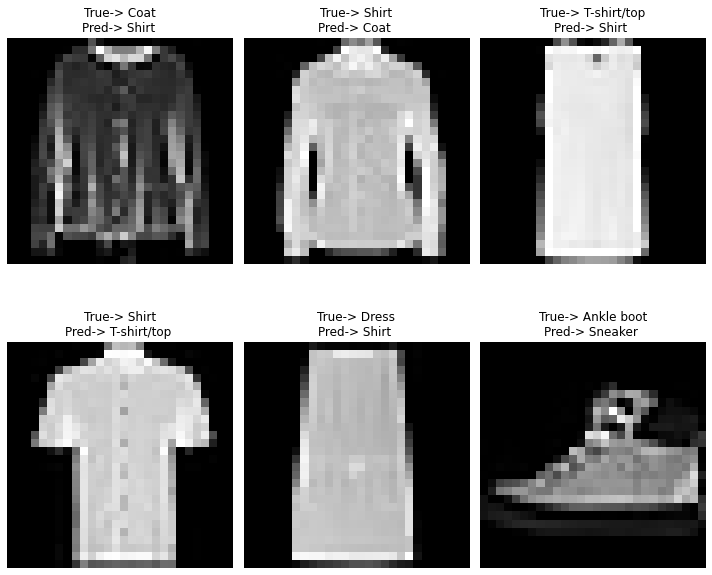

In [32]:
def imshow(img_tensor):
    img = img_tensor.cpu().squeeze()  # removes extra dims like [1, 28, 28] → [28, 28]
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.figure(figsize=(10, 9))
for i in range(6):
    img, pred, target = misclassified[i]
    plt.subplot(2, 3, i + 1)
    imshow(img)
    plt.title(f"True-> {classes[target]}\nPred-> {classes[pred]} ")
plt.tight_layout()
plt.show()